<a href="https://colab.research.google.com/github/GiselaCS/Mujeres_Digitales/blob/main/5)_Regularizacion_L1_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ¿Qué variables destacadas influyen en el precio de la vivienda?

In [1]:
# Cargar paquetes
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

# mostrar plots inline in Jupyter Notebook
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
# Establecer ruta de acceso en drive
import os
print(os.getcwd())
os.chdir("/content/gdrive/My Drive")

Mounted at /content/gdrive
/content


In [ ]:
%cd '/content/gdrive/MyDrive/Bootcamp SENA 2021/Semana 9/'

/content/gdrive/MyDrive/Bootcamp SENA 2021/Semana 9


## Metas (4 min)

Como hemos comentado en casos anteriores, uno de los desafíos fundamentales en la ciencia de datos y el aprendizaje automático es desarrollar modelos que se comporten bien con datos fuera de muestra. Muy a menudo, tenemos a nuestra disposición modelos que admiten una gran cantidad de *parámetros*, o *grado de complejidad* (por ejemplo, número de características de un regresor, la profundidad de un árbol de decisión, número de clusters en un algoritmo de clustering, etc. .). Cuanto más complejo sea nuestro modelo, más dependiente será de nuestros datos de entrenamiento y menos aplicable será de manera más general (es decir, *sobreajuste*). Por el contrario, si nuestro modelo es demasiado simple, existe una alta probabilidad de que sea menos preciso y, por lo tanto, nuevamente no sea aplicable de manera más general (es decir, *desajuste*). ¿Cómo elegimos el nivel adecuado de complejidad para nuestros modelos?

En este caso, aprenderá el concepto de **regularización**. Aprenderá cómo la regularización puede ayudar a prevenir el sobreajuste / desajuste en sus modelos. Nos centraremos en los métodos de regularización para la regresión lineal; sin embargo, estas técnicas también se aplican a otros modelos.

## Introduccion (5 min)

**Contexto de negocio.** El negocio inmobiliario moderno está cada vez más dominado por grandes cantidades de datos. La inversión inmobiliaria requiere un juicio sólido y una predicción precisa del precio para determinar si una propiedad es una inversión adecuada. Dada la naturaleza ilíquida de las inversiones inmobiliarias, hay una serie de complicaciones que pueden surgir al fijar el precio de una propiedad. Por tanto, es de gran interés para los inversores inmobiliarios conocer qué variables inciden en los precios de la vivienda para poder planificar sus carteras de inversión con mayor claridad y confianza. Recientemente se unió a la división de crecimiento de la vivienda en una corporación multinacional y se le ha asignado la tarea de identificar los factores que afectan los precios de la vivienda.

**Problema de negocio.** Responder: **"¿Qué variables son más importantes para predecir los precios de las viviendas?"**

**Contexto analitico.** El caso procederá de la siguiente manera: 1) explorará los datos para obtener una idea de las funciones útiles; 2) aplique la regularización L1 para reducir el número de variables en su modelo lineal inicial; 3) aplicar la regularización L2 para hacer frente a la multicolinealidad y reducir aún más el recuento de variables; y finalmente 4) use la regularización L1 y L2 juntas a través de elastic net para obtener los beneficios de ambos en un modelo.

## Introducción a los datos de precios de viviendas de Saratoga (5 min)

Carguemos la data en un `pandas` DataFrame. Hay 15 features que se pueden usar para predecir el ```price``` de una casa:

Variable de interes:
1. price (millions of US dollars)

Features numericos no categoricos:
1. **lotSize**: size of the lot in acres
2. **age**: age of the house in years
3. **landValue**: value of the land in US dollars
4. **livingArea**: living area in square feet
5. **pctCollege**: percent of the neighborhood that graduated college

Features numericos categoricos:
1. **bedrooms**: number of bedrooms
2. **fireplaces**: number of fireplaces
3. **bathrooms**: number of bathrooms
4. **rooms**: number of rooms

Features No-numericos categoricos:
1. **heating**: what type of heating the house uses
2. **fuel**: what type of fuel the house uses
3. **sewer**: what type of sewer system the house has
4. **waterfront**: whether or not the house has a waterfront
5. **newConstruction**: whether or not the house has new construction
6. **centralAir**: whether or not the house has a central air system

In [2]:
# Cargar la data
df = pd.read_csv('saratoga-houses_clean.csv')
df.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,0.132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,0.181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,0.109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,0.155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,0.086060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes


In [3]:
df.shape

(1728, 16)

## Exploración de las relaciones de características a través de la visualización de datos (20 min)

Comencemos visualizando la relación entre las variables y los precios de la vivienda mediante diagramas de dispersión 2D, comenzando con las características numéricas no categóricas:

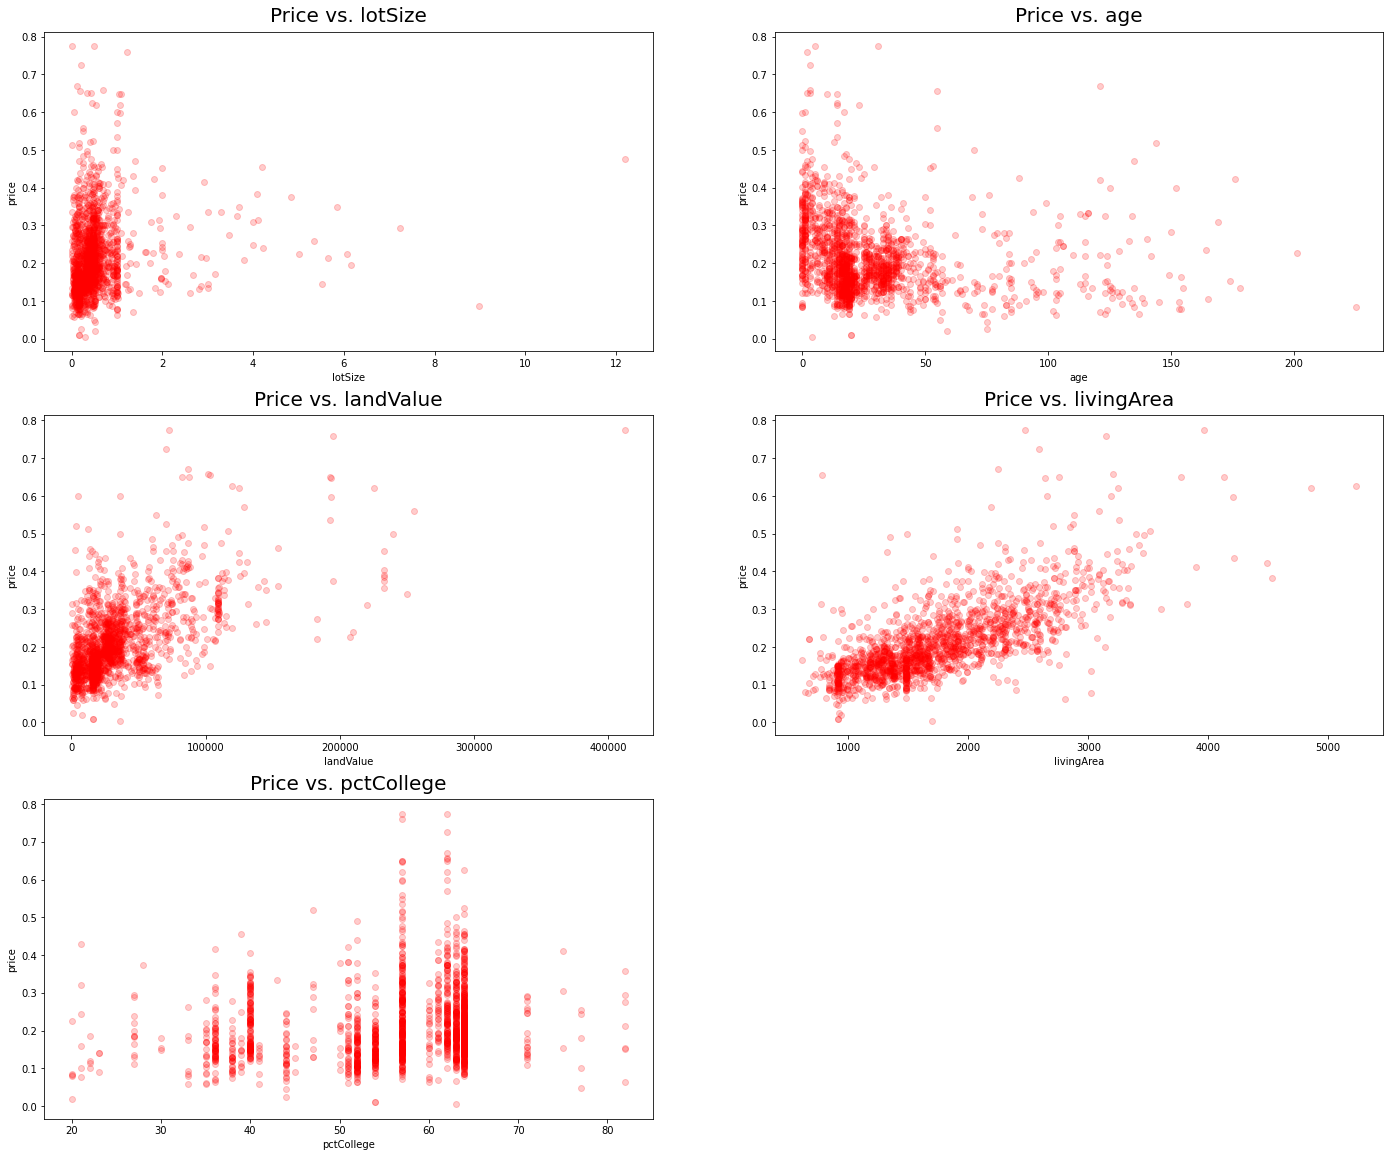

In [ ]:
# features numericos no categoricos
plt.figure(figsize=(24,20))
varstolook = ['lotSize', 'age', 'landValue', 'livingArea', 'pctCollege']
for i,feature in enumerate(varstolook):
    plt.subplot(3,2,i+1)
    colvalues = df[feature]
    plt.scatter(colvalues.values, df.price.values, alpha=0.20, edgecolor=None, color='red')
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title("Price vs. " + feature, fontsize=20, verticalalignment='bottom');

Se obervan pocas observaciones. Primero, ```livingArea```, ```landValue```, y ```lotSize``` estan correlacionadas positivamente con los precios de las casas. Segundo, la edad de la casa esta inversamente correlacionada con el precio, hay un punto en el cual la relacion se vuelve insignificante. De manera interesante, la variable ```pctCollege``` muestra clusters alrededor de ciertos porcentajes; sin embargo, no parece tener una relacion fuerte con el precio. 

Veamos las características categóricas numéricas para ver si podemos notar algún patrón significativo:

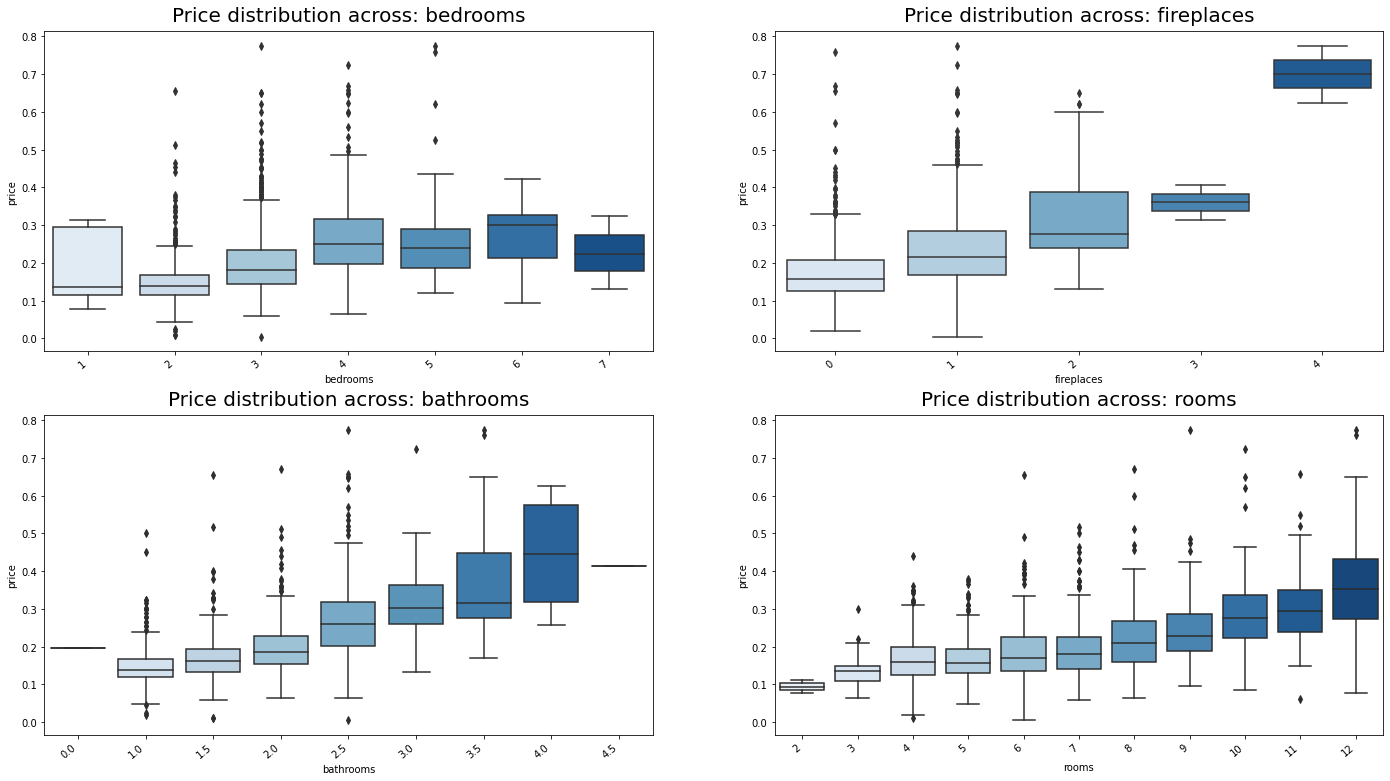

In [4]:
# features numericos categoricos 
plt.figure(figsize=(24,20))
varstolook = ['bedrooms', 'fireplaces', 'bathrooms', 'rooms']
for i,feature in enumerate(varstolook):
    plt.subplot(3,2,i+1)
    pl2 = sns.boxplot(x=feature, y = "price", data = df, palette="Blues")
    pl2.set_xticklabels(pl2.get_xticklabels(), rotation=40, ha="right");
    plt.title("Price distribution across: " + feature, fontsize=20, verticalalignment='bottom');

Se logra ver la relacion fuerte en ```rooms```, ```bathrooms```, y ```fireplaces``` con los precios de casas. Esto es esperado debido a que una casa mas grande tiene mas cuartos y requiere un mayor precio. Respecto a ```bedrooms```, se logra ver una tendencia creciente de precios a medida que aumenta, pero es debil en low (1) y high (7).

### Ejercicio 1: (10 min)

Cree diagramas de caja para visualizar cada característica categórica no numérica frente a los precios de cada valor de categoría dentro de esas características categóricas. Debe tener seis gráficos con diagramas de caja para cada valor de categoría, uno para cada característica categórica no numérica:

1. `heating`
2. `fuel`
3. `sewer`
4. `waterfront`
5. `newConstruction`
6. `centralAir`

**Respuesta.** 

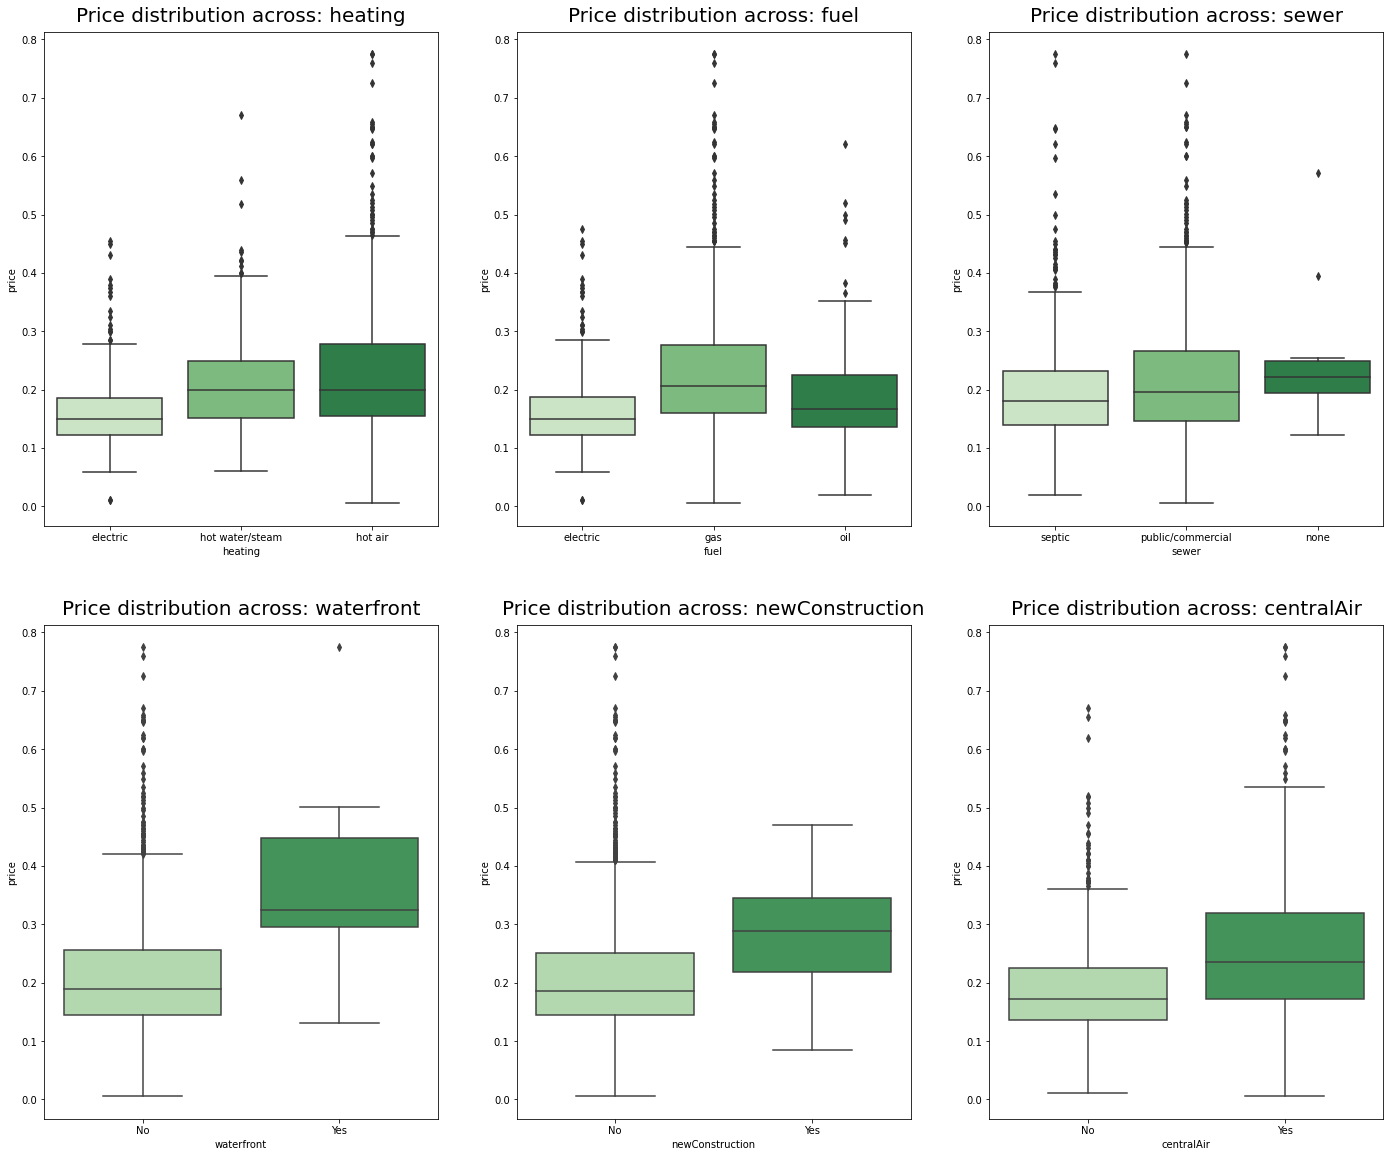

In [5]:
#Posible solucion
plt.figure(figsize=(24,20))
varstolook = ['heating', 'fuel','sewer', 'waterfront', 'newConstruction', 'centralAir']
for i,feature in enumerate(varstolook):
    plt.subplot(2,3,i+1)
    pl2 = sns.boxplot(x=feature, y = "price", data = df, palette="Greens")
    pl2.set_xticklabels(pl2.get_xticklabels(), rotation=0, ha="center");
    plt.title("Price distribution across: " + feature, fontsize=20, verticalalignment='bottom');

Como era de esperar, una propiedad frente al mar, las unidades de nueva construcción y las casas con aire acondicionado central van acompañadas de precios más altos. Si bien es más débil, existen algunas diferencias en las variables de calefacción, combustible y alcantarillado. Los sistemas de calefacción de aire caliente, gas combustible y alcantarillado público / comercial cobran precios de vivienda más altos que sus valores categóricos adyacentes.

### Exercise 2: (4 min)

Hubo algunas relaciones que pueden no haberse esperado, como la débil relación entre ```pctCollege``` y los precios de las viviendas. ¿Cuál de los siguientes puede ser un posible impulsor externo de esta débil relación?

A. Los vecindarios están situados cerca de excelentes servicios, lo que hace subir todos los precios de las viviendas.

B. Los residentes del vecindario son diversos y tienen una distribución uniforme de los niveles de ingresos y educación.

C.La gente tiende a vivir en barrios donde viven sus amigos.

D. El procedimiento de recopilación de datos para ```pctCollege``` se tomó por teléfono

**Respuesta.** (B). 

La respuesta (A) no lleva de inmediato a ninguna conclusión sobre por qué existe una relación débil entre el precio de la vivienda y el porcentaje de universidad. Todo lo que (A) implica es que todas las casas tienen un precio más alto debido a la proximidad a comodidades atractivas y nada sobre la distribución de los precios de las casas.

La respuesta (B) es la opción ideal, ya que tener diversos residentes en cada vecindario, en términos de ingresos y nivel de educación, conducirá a relaciones débiles para predecir los precios de las viviendas a partir de estas cantidades. Si bien puede ser cierto que los residentes de ingresos más altos poseen casas más caras, la variable de porcentaje de la universidad es relativa a un vecindario, por lo que un efecto promedio debilitará la relación con el precio de cualquier hogar si el vecindario está bien representado desde el punto de vista educativo.

La respuesta (C) probablemente conduciría a una relación más fuerte entre el porcentaje de precios universitarios y de la vivienda si fuera cierta en este conjunto de datos. Los amigos a menudo tienen intereses similares y pueden tener antecedentes educativos similares, lo que podría influir en los promedios universitarios porcentuales del vecindario para que se correlacionen más con los precios de las viviendas.

Con respecto a la respuesta (D), no nos dice nada sobre la relación entre el porcentaje de universidad y el precio, por lo que es incorrecta. Sin embargo, es importante entender que los datos en este caso fueron adquiridos por algún método. Por lo tanto, puede haber errores o sesgos en los datos proporcionados. Si bien no exploraremos los métodos de adquisición de datos en este caso, si los datos se recopilaron por teléfono, sería importante conocer la tasa de respuesta por ubicación para determinar si cada vecindario estaba representado por igual.


## Primer modelo (10 min)

### Preparar la data (5 min)

Antes de comenzar a modelar los datos, hagamos algunas transformaciones simples. Primero, transformemos las variables categóricas con solo dos categorías en valores binarios donde 1 indica que el efecto está presente y cero indica que el efecto no está presente. Esto permitirá una fácil estandarización de cada característica presente en los datos:

In [6]:
# Encoding las variables categoricas no numericas 
df2 = pd.get_dummies(df, columns=['heating', 'fuel'], drop_first=False)
df2 = pd.get_dummies(df2, columns=['sewer'], drop_first=True)
#se convierten los valores True and False in numeric 
df2.replace({'waterfront': {"No":0, "Yes":1},
             'newConstruction': {"No":0, "Yes":1},
             'centralAir': {"No":0, "Yes":1}}, inplace=True)

In [ ]:
df2

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,waterfront,newConstruction,centralAir,heating_electric,heating_hot air,heating_hot water/steam,fuel_electric,fuel_gas,fuel_oil,sewer_public/commercial,sewer_septic
0,0.132500,0.09,42,50000,906,35,2,1,1.0,5,0,0,0,1,0,0,1,0,0,0,1
1,0.181115,0.92,0,22300,1953,51,3,0,2.5,6,0,0,0,0,0,1,0,1,0,0,1
2,0.109000,0.19,133,7300,1944,51,4,1,1.0,8,0,0,0,0,0,1,0,1,0,1,0
3,0.155000,0.41,13,18700,1944,51,3,1,1.5,5,0,0,0,0,1,0,0,1,0,0,1
4,0.086060,0.11,0,15000,840,51,2,0,1.0,3,0,1,1,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,0.289000,0.38,32,24200,2310,61,5,1,2.5,11,0,0,0,0,0,1,0,1,0,1,0
1724,0.285000,0.94,37,36200,2564,61,4,1,2.5,11,0,0,0,0,0,1,0,1,0,1,0
1725,0.194900,0.39,9,20400,1099,51,2,0,1.0,3,0,0,0,0,1,0,0,1,0,1,0
1726,0.125000,0.24,48,16800,1225,51,3,1,1.0,7,0,0,0,0,1,0,0,1,0,1,0


A continuación, dividamos los datos en un conjunto de entrenamiento, un conjunto de prueba y un conjunto de validación. Hemos extraído un conjunto de validación, ya que más adelante necesitaremos realizar algunos ajustes de parámetros en nuestro modelo (consulte también el ejercicio 4 para ver una variante de validación cruzada). Elegimos retener el 20 por ciento de los datos para el conjunto de prueba y tener un conjunto de validación del 16 por ciento (que es el 20 por ciento del tamaño del conjunto de entrenamiento):

In [7]:
# Listos para una multiple regression
X = df2.drop(['price'], axis=1)
y = df2[['price']].values.ravel()

# Split Train, Validation y Test Data
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_vali, y_train, y_vali = train_test_split(X_rest, y_rest, test_size=0.20, random_state=0)

Finalmente, normalicemos los datos. Como hemos visto con los algoritmos de agrupación en clústeres, las escalas inconsistentes entre variables pueden afectar negativamente el rendimiento de varias técnicas de aprendizaje automático. Resulta que la regularización es una de esas técnicas (discutiremos esto más adelante):

In [ ]:
training_mean = X_train.mean()
training_mean

lotSize                        0.503439
age                           28.131222
landValue                  34617.393665
livingArea                  1764.458824
pctCollege                    55.458824
bedrooms                       3.184615
fireplaces                     0.602715
bathrooms                      1.898190
rooms                          7.056109
waterfront                     0.008145
newConstruction                0.043439
centralAir                     0.369231
heating_electric               0.190045
heating_hot air                0.641629
heating_hot water/steam        0.168326
fuel_electric                  0.192760
fuel_gas                       0.690498
fuel_oil                       0.116742
sewer_public/commercial        0.709502
sewer_septic                   0.286878
dtype: float64

In [ ]:
# Obtener la media y desviacion de la data de training data
training_mean = X_train.mean()
training_std =  X_train.std()

# Centrar la data (algo usual en tecnicas de regularizacion)
X_train = (X_train - training_mean) / training_std # normalizar 
X_vali= (X_vali- training_mean) / training_std # normalizar
X_test = (X_test - training_mean) / training_std # normalizar 

In [ ]:
print(X_train.shape)
print(X_vali.shape)
print(X_test.shape)

(1105, 20)
(277, 20)
(346, 20)


### Ajustar el modelo de multiple regression(5 min)

Comencemos con un modelo de regresión lineal simple usando todas las características dadas:

In [ ]:
# Ajustar el modelo a train
model_linear = sm.OLS(y_train, sm.add_constant(X_train))
original_linear = model_linear.fit()
print(original_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     115.6
Date:                Fri, 16 Jul 2021   Prob (F-statistic):          3.15e-237
Time:                        17:32:17   Log-Likelihood:                 1592.8
No. Observations:                1105   AIC:                            -3148.
Df Residuals:                    1086   BIC:                            -3052.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Aquí, vemos que las características de calefacción, combustible y alcantarillado no son estadísticamente significativas, mientras que las variables de área habitable, valor de la tierra, frente al mar y nueva construcción son significativas. Estos resultados son consistentes con la fuerza de las relaciones que observamos en nuestras visualizaciones de datos anteriores.

## ¿Cómo puede ayudar la regularización a modelar los datos? (25 min)

Hemos mencionado brevemente la **regularización** antes, y cómo es una especie de "penalización" por tener demasiadas variables inútiles en un modelo. Su objetivo es mejorar las predicciones del modelo fuera de la muestra reduciendo la complejidad del modelo y evitando el sobreajuste. Un modelo equilibrado solo utilizará la complejidad suficiente para capturar la tendencia general de los datos; es decir, el número mínimo de parámetros del modelo posible para obtener un ajuste aceptable.

Motivados por la gran cantidad de variables insignificantes presentes en la regresión, nos gustaría reducir nuestra posibilidad de sobreajuste y eliminar algunas de las variables menos útiles. Emplearemos una herramienta llamada **regularización L1** para ayudarnos en este objetivo.

### Aplicar LASSO feature selection (15 min)

Un regression model que utiliza la regularizacion L1 regularization es el llamado **LASSO (Least Absolute Shrinkage and Selection Operator) regression**. Regularizacion L1 adiciona la magnitud absoluta de los coeficientes del modelo de regresion ($\beta_j$) usando la funcion de perdida dada por ordinary least squares (OLS),pero multiplicando por un termino de escalamiento $\lambda$:

$$\sum_{i=1}^N{\big(y_i - \sum_{j=1}^p{x_{ij}\beta_j}}\big)^2 + \color{red}{\lambda \sum_{j=1}^{p}\big| \beta_j \big|} .$$

Recuerde que la regresión lineal múltiple busca minimizar la función objetivo $Pérdida(Datos\ |\ Modelo) $, donde la pérdida generalmente se define como la diferencia al cuadrado entre los valores $y$ predichos y verdaderos (en este caso $y$ son los precios de la vivienda). Extender la regresión lineal múltiple para usar la regularización L1 requiere agregar un término adicional ${\lambda \sum_{j=1}^{p}\big| \beta_j \big|}$ para penalizar el incremento de la complejidad del modelo.

La regularización L1 reduce los coeficientes $\beta_j$ hacia cero, ya que cualquier $\beta_j$ grande aumentará en gran medida la función objetivo anterior, que estamos buscando minimizar. El valor de $\lambda $ establece la fuerza de la regularización; los valores más grandes de $\lambda $ afectarán cada vez más a los coeficientes $\beta_j$.


Ajustemos una regresión lineal múltiple con un término de regularización L1. En el método ```linear_model.Lasso()``` la notación ```alpha``` se refiere al valor $\lambda$ que definimos anteriormente. Primero elegimos un $\lambda$ pequeño para realizar solo una regularización débil. Si alguno de los coeficientes se establece en cero con esta regularización débil, es muy probable que no sea significativo para las predicciones del precio de la vivienda.

In [8]:
# Ajustar el modelo L1 
model_l1 = linear_model.Lasso(alpha=0.00001, fit_intercept=True) # mayor alpha para una mayor regularizacion 
results_l1 = model_l1.fit(X_train, y_train)

**Nota:** Hemos establecido $ \lambda = 0.00001 $ aquí como ejemplo. Aprenderá a elegir un $\lambda$ apropiado más adelante en el caso.

A continuación se muestran los nombres de los coeficientes del modelo seguidos de los valores de ajuste $\beta$. Los coeficientes se ordenan de menor a mayor para facilitar la visualización. Estamos buscando los coeficientes que sean aproximadamente cero, ya que esto indica que la regularización L1 ha eliminado estas características de la predicción:

In [9]:
sorted(zip(X_train.columns, results_l1.coef_), key=lambda x: x[1])

[('newConstruction', -0.05257303429059906),
 ('heating_hot water/steam', -0.010451584241331068),
 ('bedrooms', -0.007687513100320382),
 ('age', -0.0001391178711283825),
 ('pctCollege', -8.717975677669849e-05),
 ('heating_electric', 0.0),
 ('fuel_electric', -0.0),
 ('fuel_oil', -0.0),
 ('sewer_public/commercial', 0.0),
 ('landValue', 8.529066435148389e-07),
 ('livingArea', 7.599679680737332e-05),
 ('sewer_septic', 0.001365262258259017),
 ('rooms', 0.0028435240421552555),
 ('fireplaces', 0.0031063279732668906),
 ('heating_hot air', 0.003870107239042948),
 ('lotSize', 0.006595345655467762),
 ('centralAir', 0.00688382136046611),
 ('fuel_gas', 0.0076235839222495196),
 ('bathrooms', 0.01825794702118082),
 ('waterfront', 0.10520743743420205)]

Los resultados de la regularización L1 muestran que los coeficientes de **heating_electric**, **fuel_electric**, y **fuel_oil** son cero. Esta es la idea de la regularización L1 aplicando la selección de características. Es decir, agregar la restricción de complejidad del modelo a la función objetivo ha obligado al procedimiento de ajuste a establecer algunos de los coeficientes en cero (tales coeficientes que luego consideramos no importantes).

Eliminemos estas tres variables en el futuro y ajustemos un modelo de regresión lineal múltiple (sin regularización):

In [10]:
# Reducir el numero de variables basados en los resultado L1
cols_to_drop = ['heating_electric','fuel_oil','fuel_electric']

X_train_simplified = X_train.drop(columns=cols_to_drop)
X_vali_simplified = X_vali.drop(columns=cols_to_drop)
X_test_simplified = X_test.drop(columns=cols_to_drop)

# Para uso futuro hacemos lo mismo en el resto de la data
X_simplified=X.drop(columns=cols_to_drop)
X_rest_simplified=X_rest.drop(columns=cols_to_drop) #recordar X_rest es train+validation set

In [11]:
# Re ajustar el modelo de multiple linear regression (no regularizacion)
model_linear = sm.OLS(y_train, sm.add_constant(X_train_simplified))
res_linear = model_linear.fit()
print(res_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     122.5
Date:                Tue, 28 Sep 2021   Prob (F-statistic):          2.80e-238
Time:                        20:36:52   Log-Likelihood:                 1592.8
No. Observations:                1105   AIC:                            -3150.
Df Residuals:                    1087   BIC:                            -3059.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Vemos que el nuevo modelo tiene los mismos valores de R cuadrado (a tres dígitos significativos) y la puntuación AIC ha disminuido. Esto es importante ya que indica que al eliminar las dos características **heating_electric** y **fuel_oil**, hemos perdido un poder de predicción insignificante en términos de explicar la variación en los datos. Simplificar modelos como este es muy útil en la práctica y puede conducir a una mejor comprensión de los efectos que tiene cada característica en la variable de predicción.

### Ejercicio 3: (4 min)

Reflexionando sobre el uso de L1 anterior, ¿cuál de los siguientes sería un caso útil para la regularización de L1?

A. Tiene datos que exhiben grandes características numéricas

B. Tiene una gran cantidad de características y su objetivo es seleccionar una menor cantidad de características destacadas

C. Tiene una pequeña cantidad de características muy importantes

D. Le gustaría evitar una falta de adaptación

**Respuesta.** (B).

La respuesta (A) es incorrecta, ya que cuando preparamos los datos eliminamos la media de cada característica. Esto se hizo específicamente porque cuando se usa la regularización, la magnitud de los coeficientes $ \beta$ importa. El término agregado para la complejidad del modelo en la función objetivo del modelo funciona mejor cuando las características son todas de magnitud similar, de modo que ninguna característica recibe un tratamiento preferencial en el procedimiento de optimización de ajuste.

La respuesta (B) es correcta y así es como usamos la regularización L1 en este caso. Encontramos dos características que tenían sus coeficientes establecidos en cero al agregar una restricción L1 al modelo de regresión múltiple. Por lo tanto, hemos realizado la selección de funciones.

La respuesta (C) es incorrecta ya que una pequeña cantidad de características muy importantes no indica la necesidad de regularización L1. La regularización L1 se aplica regularmente para que la selección de características reduzca algunos de los coeficientes a cero. Si se sabe que todas las características son muy importantes, es posible que la regularización L1 no sea la mejor opción.

La respuesta (D) confunde desajuste con sobreajuste. Se aplican técnicas de regularización para evitar el sobreajuste al reducir la complejidad del modelo.

### Identificación de multicolinealidad y eliminación de más características (5 min)

A continuación, echemos un vistazo y veamos si la multicolinealidad está presente en las características. Recuerde que la multicolinealidad es a menudo una fuente de complejidad innecesaria en un modelo que puede conducir a inestabilidad numérica y sobreajuste, por lo que tiene sentido filtrarla. Echemos un vistazo a las correlaciones entre las características numéricas no categóricas a través de una matriz de correlación:

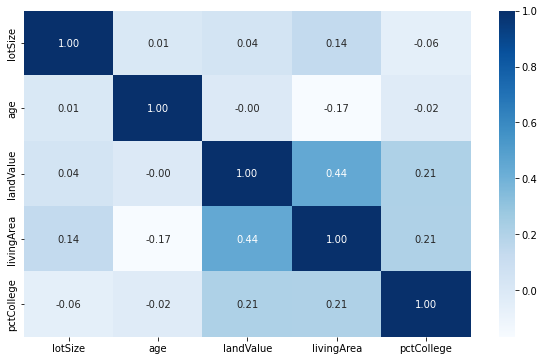

In [12]:
# Crear un heatmap de correlacion para variables continuas
features = ['lotSize', 'age', 'landValue', 'livingArea', 'pctCollege']
fig, ax = plt.subplots(figsize=(10,6))
corr = X_train_simplified[features].corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, cmap="Blues", annot=True, fmt=".2f");

La mayoría de las correlaciones que no se encuentran a lo largo de la diagonal principal son bajas, pero vemos que existe una correlación considerable entre el valor de la tierra y la superficie habitable. Si bien no es una correlación terriblemente alta en 0.44, esto no es ideal desde el punto de vista de la regresión lineal e indica que existe multicolinealidad.

La regularización L1 a menudo sufre con las predicciones cuando los datos exhiben linealidad múltiple, ya que el algoritmo de optimización no funciona tan bien. Afortunadamente, existe otro tipo de regularización, **regularización L2**, que es muy buena para abordar la multicolinealidad. Procedamos a aplicar la regularización L2 al conjunto actual de características.

## Aplicar L2 regularization para resolver multicolinealidad (40 min)

Un modelo de regresión lineal que utiliza la regularización L2 se denomina **regresión Ridge**. La regularización L2 agrega la magnitud al cuadrado de los coeficientes del modelo de regresión ($ \beta_j$) a la función de pérdida de OLS:

$$\sum_{i=1}^N{\big(y_i - \sum_{j=1}^p{x_{ij}\beta_j}}\big)^2 + \color{purple}{\lambda \sum_{j=1}^{p}\beta_j^2} .$$

La regularización L2 también reduce los coeficientes $ \beta_j$ hacia cero, sin embargo, los efectos de la reducción suelen ser menores que la regresión LASSO. Ajustemos el modelo y examinemos los nuevos coeficientes:

In [13]:
# Ajustar el modelo
model_l2 = linear_model.Ridge(alpha=46.2, fit_intercept=True) # mayor alpha para mayor regularizacion
results_l2 = model_l2.fit(X_train_simplified, y_train)

A continuación se muestran los nombres de los coeficientes del modelo seguidos de los valores de ajuste $ \ beta $. Los coeficientes se ordenan de menor a mayor:

In [14]:
sorted(zip(X_train_simplified.columns, results_l2.coef_), key=lambda x: x[1])

[('newConstruction', -0.024655273894643278),
 ('bedrooms', -0.007217409045343731),
 ('heating_hot water/steam', -0.005093864640034345),
 ('sewer_public/commercial', -0.0007303828902715658),
 ('age', -0.0001466766384787652),
 ('pctCollege', -4.258766272785721e-05),
 ('landValue', 8.56120637603638e-07),
 ('livingArea', 7.679064862414486e-05),
 ('sewer_septic', 0.0012319421319091316),
 ('rooms', 0.002496175930048177),
 ('fuel_gas', 0.0029919243697705627),
 ('fireplaces', 0.003999221576418922),
 ('lotSize', 0.00543966108855792),
 ('heating_hot air', 0.006227327130546284),
 ('centralAir', 0.006799053290520142),
 ('bathrooms', 0.014665294980545534),
 ('waterfront', 0.01714070361547652)]

Aquí, vemos que ```livingArea``` y ```landValue``` tienen los coeficientes más grandes. Esto se esperaba dado que la exploración de visualización de datos original de este análisis mostró una relación significativa entre estas variables y los precios de la vivienda.

Sin embargo, es importante preguntar por qué elegimos usar $\lambda = 46.2 $ en este ajuste. El valor de $\lambda $ puede afectar significativamente los coeficientes del modelo, por lo que debe elegirse con cuidado. La siguiente sección explora un método para elegir gráficamente un valor $\lambda$ óptimo.

### Como tunear el parametro de regularizacion $\lambda$  (35 min)

Para seleccionar un parámetro apropiado $ \lambda$, usaremos el error cuadrático medio (MSE) del modelo aplicado a nuestro conjunto de validación. Recuerde que el MSE del modelo se calcula comparando las predicciones del modelo con los valores reales. Aquí, esto significa comparar los precios de la vivienda pronosticados del modelo regularizado L2 con los precios reales de la vivienda. Los valores más bajos de error cuadrático medio indican un mejor rendimiento del modelo.

Examinemos los valores $\lambda$ y veamos los efectos en el rendimiento del modelo. Compararemos el rendimiento en los conjuntos de entrenamiento y validación. Recuerde que los valores de $\lambda$ más altos conducen a una regularización más fuerte:

In [15]:
# buscar diferentes valores de lambda
lambdas = np.arange(0.1, 100.0, 0.1)

coefs = []
mse_train = []
mse_vali = []
for l in lambdas:
    ridge = linear_model.Ridge(alpha=l, fit_intercept=True)
    ridge.fit(X_train_simplified, y_train)
    mse_train.append(mean_squared_error(y_train, ridge.predict(X_train_simplified))) # train data
    mse_vali.append(mean_squared_error(y_vali, ridge.predict(X_vali_simplified))) # validation data

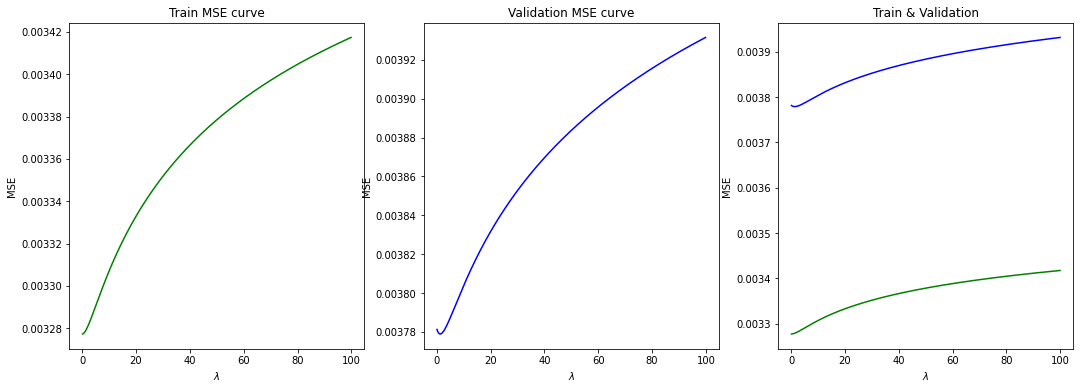

In [16]:
# Graficar los resultados
fig, ax1 = plt.subplots(1,3,figsize=(18,6))

ax1[0].plot(lambdas, mse_train, 'g-')
ax1[0].set_title('Train MSE curve')

ax1[1].plot(lambdas, mse_vali, 'b-')
ax1[1].set_title('Validation MSE curve')

#Poner dos figuras en la misma 
ax1[2].plot(lambdas, mse_train, 'g-')
ax1[2].plot(lambdas, mse_vali, 'b-')
ax1[2].set_title('Train & Validation')

for ax in ax1.flat:
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('MSE')
        
plt.show()

Aquí, vemos que el modelo está ligeramente sobreajustado cuando $\lambda$ es pequeño. El MSE del conjunto de validación es mucho más alto que el MSE de train y el modelo no está regularizado en su mayoría (es decir, el modelo es una regresión lineal sin términos adicionales en la función de optimización).

El modelo no se ajusta ligeramente cuando $\lambda$ es grande. El efecto de un $\lambda$ grande es aumentar la fuerza de la regularización, hacer que el modelo esté restringido en los coeficientes que puede usar para ajustar los datos. Con un $\lambda$ grande, vemos que el modelo tiene problemas tanto en train como en los datos de prueba (alto MSE tanto para el train como para los datos de prueba), lo que indica que el modelo está desajustado.

Por lo tanto, debemos elegir una lambda que equilibre el sobreajuste y el desajuste. A partir de la curva MSE del conjunto de validación, vemos que el mínimo se logra entre $40$ y $50$. De hecho, el siguiente código muestra que el mínimo se alcanza cuando $\lambda = 46.1 $. Esta fue la motivación para elegir $\lambda $ en la sección anterior. En general, recomendamos utilizar un método gráfico de este tipo para comprender los efectos que tiene la regularización en un modelo de regresión múltiple.

In [17]:
min_index=mse_vali.index(min(mse_vali))
print("The optimal lambda is: ", lambdas[min_index])
print("Validation MSE=",mse_vali[min_index])
print("Train MSE=", mse_train[min_index])

The optimal lambda is:  1.3000000000000003
Validation MSE= 0.003778950861773298
Train MSE= 0.0032789261946279333


### Ejercicio 4: (15 min):

Hay un par de desventajas al extraer un conjunto de validación *fijo* desde el comienzo de nuestro análisis: (i) si nuestro conjunto de datos es pequeño, el tamaño de nuestro conjunto de entrenamiento se reduce y nuestros modelos tendrán menos poder predictivo, y (ii)) la elección del parámetro de regularización terminará dependiendo en gran medida del conjunto de validación. Por lo tanto, a menudo se recomienda utilizar un método como la validación cruzada de $k$-fold para estimar el mejor parámetro $\lambda$.

Estime el mejor $\lambda $ usando el siguiente procedimiento:

1. Hacer un split de `X_rest_simplified` en $k=10$ folds usando la funcion `sklearn.model_selection` llamada `KFold`.

2. Para cada fold $f$, normalizar la data como antes. Luego para cada $\lambda$ en `lambdas = np.arange(0.1, 100.0, 0.1)`, ajuste un modelo Ridge regression y calcule el MSE para los fold's test. Puede llamar a esto $\text{MSE}_{f,\lambda}$.

3. Para cada $\lambda$, calcular el MSE a traves de los folds; esto es $\text{MSE}_\lambda:=\frac{1}{10}\sum_{f=1}^{10} \text{MSE}_{f,\lambda}$.

4. Graficar $\lambda$ versus $\text{MSE}_\lambda$ y concluir. 

**Pista:** Puedes extraer los datos de cada pliegue usando un bucle como este:
```
kf=KFold(n_splits=10,random_state=0)

for index_train, index_test in kf.split(X_rest_simplified):
    
    #Extract the data of the fold
    X_train_fold, y_train_fold=X_rest_simplified.iloc[index_train], y_rest[index_train]
    X_test_fold, y_test_fold=X_rest_simplified.iloc[index_test], y_rest[index_test]
    ... (Rest of your code)
    
```

**Respuesta.**

In [18]:
kf=KFold(n_splits=10,random_state=0)

MSE_total=[]
for index_train, index_test in kf.split(X_rest_simplified):
    
    #Extraer la data en folds
    X_train_fold, y_train_fold=X_rest_simplified.iloc[index_train], y_rest[index_train]
    X_test_fold, y_test_fold=X_rest_simplified.iloc[index_test], y_rest[index_test]
    
    #Normalizar la data:
    training_fold_mean = X_train_fold.mean()
    training_fold_std =  X_train_fold.std()
    X_train_fold = (X_train_fold - training_fold_mean) / training_fold_std # normalizar
    X_test_fold = (X_test_fold - training_fold_mean) / training_fold_std # normalizar
   
    MSE_fold=[]

    for l in lambdas:
        ridge = linear_model.Ridge(alpha=l, fit_intercept=True)
        ridge.fit(X_train_fold, y_train_fold)
        
        #Calcular el MSE para la test data
        MSE_fold.append(mean_squared_error(y_test_fold, ridge.predict(X_test_fold)))
    
    MSE_total.append(MSE_fold)

Text(0.5, 1.0, 'Mean MSE curve')

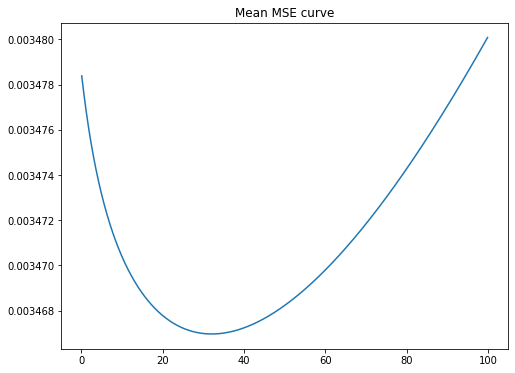

In [20]:
#Ahora, calculamos la media para cada lambda:

MSE_lambdas=np.matrix(MSE_total).mean(0).reshape(999,1)
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(lambdas, MSE_lambdas)
ax.set_title('Mean MSE curve')


In [21]:
min_index=np.argmin(MSE_lambdas)
print("The optimal lambda is: ", lambdas[min_index])
print("Average MSE is:", min(MSE_lambdas))

The optimal lambda is:  32.1
Average MSE is: [[0.00346697]]


### Ejercicio 5: (4 min)
En la regularización L2, a medida que $\lambda$ se acerca a cero, ¿cómo se comportarían las predicciones del modelo de precios de la vivienda? Compare con el caso en el que ajustamos un modelo de regresión lineal múltiple sin regularización.

A. Las predicciones del precio de la vivienda se volverían cada vez más sesgadas

B. Las predicciones del precio de la vivienda se volverían menos resistentes a la multicolinealidad presente en las características

C.Las predicciones del precio de la vivienda no cambian a medida que cambia $\lambda$

D. El modelo se volvería menos complejo, lo que conduciría a una menor variación en las predicciones.


**Respuesta.** (B).

La respuesta (A) es incorrecta ya que a medida que $\lambda$ se acerca a cero, esto reduce efectivamente la fuerza de la regularización (eliminando así el sesgo del modelo).

La respuesta (B) es correcta ya que reducir $\lambda$ reduce la fuerza de la regularización. La regularización L2 se utiliza principalmente para reducir los efectos de la multicolinealidad controlando la complejidad del modelo. Los valores más altos de $\lambda$ conducen a un modelo más regularizado, por lo que los valores menores de $\lambda $ se volverán menos resistentes a la multicolinealidad.

La respuesta (C) es incorrecta ya que las predicciones cambiarán a medida que cambie $\lambda$ ya que la regularización es parte de la función objetivo del modelo. La función objetivo se minimiza durante el ajuste del modelo y, dado que $\lambda $ es parte del procedimiento de optimización, cambiar su valor también cambiará el modelo resultante y, por lo tanto, cambiará las estimaciones del modelo.

Con respecto a la respuesta (D), disminuir $\lambda$ conduce a un modelo más complejo. Al aumentar $ \lambda$, el modelo se vuelve menos complejo, lo que ayuda a evitar el sobreajuste.

### Ejercicio 6: (10 min)

Hemos ajustado una regresión lineal múltiple regularizada L2 para predecir los datos de vivienda y observamos cómo el $\lambda $ elegido afecta las muestras train y el error de prueba. También nos gustaría ver cómo los coeficientes se ven afectados por la elección de $\lambda $. Escriba un script para cambiar el valor de $\lambda$ y observe cómo cambian los coeficientes de regresión de ajuste de Ridge. Es decir, escriba un guión para producir lo siguiente. Cada línea del gráfico corresponde al coeficiente de una sola característica a medida que cambia el valor de $\lambda $.

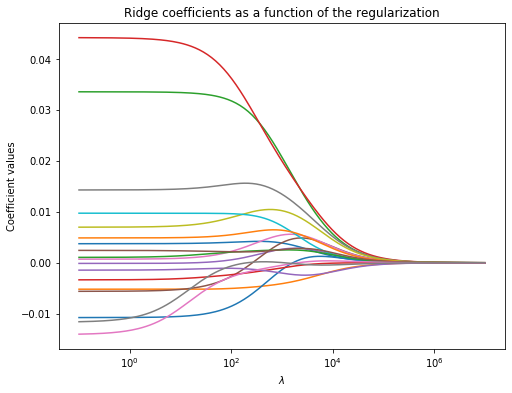

In [ ]:
Image("ridge_coef_plot.png", width=500)

**Answer.** One possible solution is shown below:

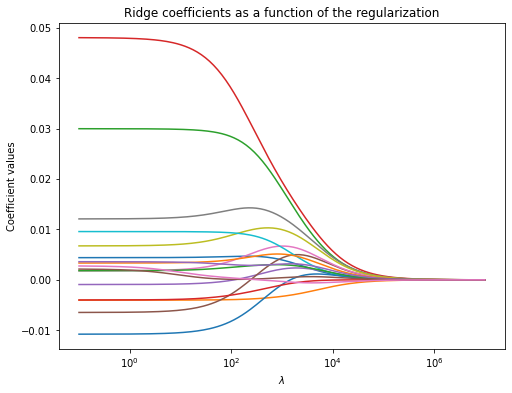

In [ ]:
# ciclo para multiples valores de lambda y guardar los coeficientes ajustados
lambdas = np.logspace(-1, 7, 200)

coefs = []
for l in lambdas:
    ridge = linear_model.Ridge(alpha=l, fit_intercept=True)
    ridge.fit(X_train_simplified, y_train)
    coefs.append(ridge.coef_)

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(lambdas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  # reverse axis
plt.xlabel('$\lambda$')
plt.ylabel("Coefficient values")
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()
#plt.savefig('ridge_coef_plot.png', bbox_inches='tight')

Cada línea anterior corresponde a la ruta de un coeficiente a medida que $\lambda $ aumenta de izquierda a derecha. Vemos que a medida que aumenta la fuerza de regularización, todos los coeficientes eventualmente se vuelven cero. Este es el efecto de reducción de la regularización, donde un $\lambda $ muy grande obligará a todos los coeficientes del modelo a cero (debido al proceso de optimización que minimiza la función objetivo). Hacer que todos los coeficientes vayan a cero conducirá a un desajuste ya que las predicciones del modelo se vuelven demasiado restringidas.

En términos de disminuir $\lambda$ a valores muy pequeños, está claro que los coeficientes del modelo eventualmente alcanzan un valor constante para valores pequeños de $\lambda$. Esto ilustra que a medida que $\lambda$ se vuelve pequeño, la regularización esencialmente desaparece y los coeficientes serán los mismos que si no se hubiera aplicado ninguna regularización. Dependiendo de los datos, esto podría provocar un sobreajuste.

Por lo tanto, existe una compensación entre el sobreajuste y el desajuste al elegir un valor $ \lambda$ óptimo. Un $\lambda$ demasiado alto puede no encajar, mientras que un $\lambda$ demasiado bajo puede sobreajustarse. Al elegir el $\lambda $ apropiado mediante una observación y un análisis cuidadosos, las técnicas de regularización pueden ser una herramienta poderosa para prevenir y controlar el sobreajuste.

## Regularizacion Elastic Net (35 min)

Ahora que hemos aplicado la regularización L1 y L2 individualmente, ¿existe algún método por el cual podamos obtener sus beneficios juntos? Afortunadamente, los beneficios de escasez de L1 y la robustez y prevención contra los beneficios de sobreajuste de L2 se pueden compartir en un método llamado **Regresión de Elastic Net**.


La regularización L1 agrega los valores absolutos de las betas a la función objetivo:

$$Loss(Data\ |\ Model) + \color{blue}{\lambda \sum_{j=1}^{p}\big| \beta_j \big|} .$$

Por otro lado, la regularización L2 agrega las magnitudes cuadradas de las betas a la función objetivo:

$$Loss(Data\ |\ Model) + \color{blue}{\lambda \sum_{j=1}^{p}\beta_j^2} .$$

Elastic net puede ser un método poderoso para fomentar tanto una solución escasa como una solución que sea robusta frente a características perjudiciales como la multicolinealidad. Dados los datos $ (y_1, ..., y_n) $ y las características observadas para cada $y_i$, a saber $ (x_{i1}, ..., x_{ip}) $, un modelo de regresión con $ p $ parámetros $(\beta_0, ..., \beta_p) $ toma la forma,

$$y_i = \sum_{j=1}^{p} x_{ij}\beta_j .$$

La regularización neta elástica combina las penalizaciones de regularización L1 y L2 para incluir tanto el valor absoluto como la magnitud al cuadrado de los coeficientes beta en la función de pérdida:


$$\sum_{i=1}^{n} (y_i - \sum_{j=1}^{p} x_{ij} \beta_j)^2 + \color{blue}{\alpha \rho \sum_{j=1}^{p}\big| \beta_j \big|} + \color{blue}{\alpha(1-\rho) \sum_{j=1}^{p}\beta_j^2}.$$

Aqui, $\alpha$ es la regularization rate, y $\rho$ controla el balance entre las regularizaciones L1 y L2 en la loss function. Cuando, $\rho = 1$ los resultados se basan solamente en una L1 penalty, $\rho = 0$ los resultados se basann en L2 penalty, mientras que cuando $0 < \rho < 1$ los resultados  da como resultado una regularización Elastic net.

De manera similar a cómo calibramos $ \lambda$ en nuestra discusión sobre la regularización L2, es útil construir gráficos en función de la tasa de regularización neta elástica $\alpha $. Examinemos una lista de diferentes valores $ \alpha $ y grafiquemos los coeficientes en función de $ \alpha $:

In [24]:
# Ciclo para diferentes valores de alpha y guardar coeficientes ajustados
alpha_list = np.logspace(-5, 1, 50)

coefs = []
for a in alpha_list:
    enet = linear_model.ElasticNet(random_state=0, alpha=a, l1_ratio=0.5, fit_intercept=True)
    enet.fit(X_train_simplified, y_train)
    coefs.append(enet.coef_.ravel())

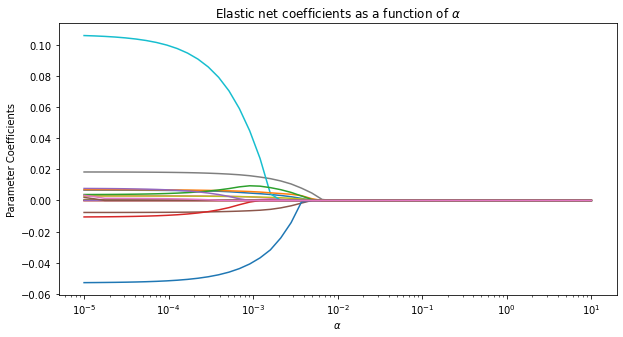

In [25]:
# Graficar 
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alpha_list, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  # reverse axis
plt.xlabel(r'$\alpha$')
plt.ylabel('Parameter Coefficients')
plt.title(r'Elastic net coefficients as a function of $\alpha$')
plt.axis('tight');

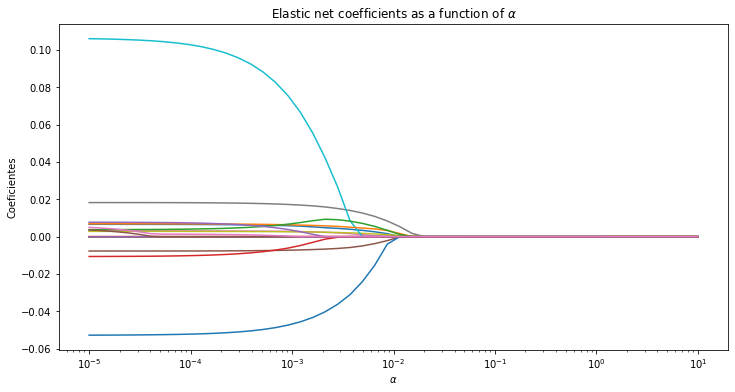

In [29]:
alpha_list = np.logspace(-5, 1, 50)

coefs = []
for a in alpha_list:
    enet = linear_model.ElasticNet(random_state=0, alpha=a, l1_ratio=0.2, fit_intercept=True)
    enet.fit(X_train_simplified, y_train)
    coefs.append(enet.coef_.ravel())
# Graficar 
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(alpha_list, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  # reverse axis
plt.xlabel(r'$\alpha$')
plt.ylabel('Coeficientes')
plt.title(r'Elastic net coefficients as a function of $\alpha$')
plt.axis('tight');

En el gráfico anterior, vemos que a medida que $\alpha$ aumenta más allá de ~0.1, todos los coeficientes se vuelven cero. Esto indica que la regularización en tal alfa es demasiado fuerte. Por otro lado, valores de $\alpha$ muy pequeños conducen a una regularización débil. Podemos ver a medida que los valores de $\alpha $ disminuyen de derecha a izquierda, las estimaciones de los parámetros comienzan a verse afectadas de manera más significativa cerca de $ 10^{-4} $. Esto incida en ese punto que la regularización comienza a tener un efecto en el ajuste del modelo.

Ahora que tenemos una idea de cómo los coeficientes se ven afectados por $\alpha $, echemos un vistazo a cómo elegir el valor óptimo de $\alpha $.

### Un metodo para elegir el valor optimo de  $\alpha$ (10 min)

Es importante elegir un $\alpha$ óptimo. Elegir un $\alpha $ que sea demasiado grande hará que los coeficientes del modelo se vuelvan demasiado restringidos y reduzca la precisión del modelo fuera de la muestra. Por otro lado, elegir un $\alpha $ que sea demasiado pequeño puede hacer que la regularización tenga poco efecto, reduciendo así el propósito principal de la regularización como control contra el sobreajuste.

Un método para seleccionar un $\alpha $ óptimo es observar el R-cuadrado del modelo como una función de $\alpha $, y luego seleccionar el $\alpha$ que da el valor R-cuadrado más alto del conjunto de prueba. Ajustemos el modelo de regresión lineal Elastic Net para diferentes valores de $\alpha$ y veamos los efectos en el R cuadrado para los conjuntos de entrenamiento y validación (también podríamos usar la validación cruzada aquí). Tenga en cuenta que estableceremos la relación de regularización L1 y L2 (denotado como el parámetro `l1_ratio` en `linear_model.ElasticNet()`, y a menudo denotado matemáticamente como $\rho$) a 0.5 en este análisis, con la idea de equilibrar Efectos de regularización L1 y L2:

In [ ]:
# Comparar la progresion de los errores de train y test errors a medida que varia alpha
alphas = np.logspace(-5, 1, 50)
enet = linear_model.ElasticNet(random_state=0, l1_ratio=0.5, fit_intercept=True)
train_errors = list()
test_errors = list()
for alpha in alphas:
    enet.set_params(alpha=alpha)
    enet.fit(X_train_simplified, y_train)
    train_errors.append(enet.score(X_train_simplified, y_train))
    test_errors.append(enet.score(X_vali_simplified, y_vali))

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print("Optimal alpha regularization parameter : %.6f" % alpha_optim)

# Estimar los coef_ de toda la data con parametros de regularizacion optimos
enet.set_params(alpha=alpha_optim)
coef_ = enet.fit(X, y).coef_

Optimal alpha regularization parameter : 0.000687


Veamos cómo evoluciona el R-cuadrado de los datos de entrenamiento y prueba a medida que se cambia el parámetro $\alpha$:

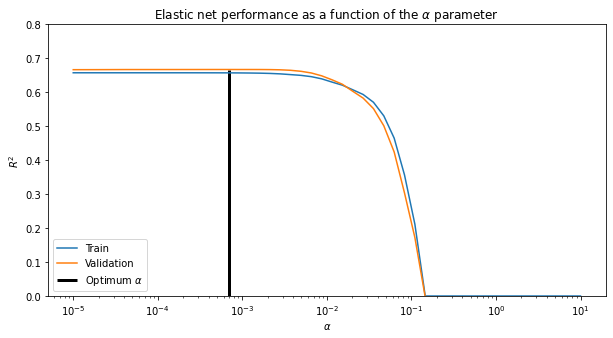

In [ ]:
# Graficar el R-squared como funcion de 
fig,ax = plt.subplots(figsize=(10,5))
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Validation')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',linewidth=3, label=r'Optimum $\alpha$')
plt.legend(loc='lower left')
plt.ylim([0, 0.8])
plt.title(r'Elastic net performance as a function of the $\alpha$ parameter')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$R^2$');

Vemos que el valor óptimo de $\alpha$ es aproximadamente 0,0006.

### Ejercicio 7: (5 min)

Al elegir los parámetros óptimos $\alpha$ y $ \lambda$, dividimos los datos en dos conjuntos, entrenamiento y validación. El conjunto de train se usa para ajustar el modelo de regresión lineal regularizado Elastic Net, mientras que el conjunto de validación se usa para calcular el R-cuadrado para cada valor diferente de $\alpha $. ¿Cuál es la razón principal para dividir en train y conjuntos de validación al elegir un $\alpha $ óptimo para esta tarea de Elastic Net? </font>

(A) Al elegir $\alpha$ utilizando datos de muestra, reducimos el riesgo de sobreajuste

(B) La complejidad del modelo se reduce, lo que conduce a una menor probabilidad de sobreajuste.

(C) Para ayudar en la precisión de la predicción del modelo fuera de la muestra, $\alpha$ se selecciona utilizando el conjunto de validación que no está involucrado en el proceso de ajuste.

(D) Dado que $\alpha $ es una sola variable, la división en train y conjuntos de validación reduce el tiempo de cálculo y ayuda en el desarrollo del modelo.

**Respuesta.** (C). 

La respuesta (A) es incorrecta, ya que elegimos $\alpha$ usando datos de prueba fuera de la muestra, no los datos del train dentro de la muestra que se usaron para ajustar el modelo lineal.

La respuesta (B) es incorrecta ya que la complejidad del modelo no se reduce al dividirlo en conjuntos de train y validación. La complejidad del modelo permanece sin cambios, ya que los datos en los que se ajusta o se prueba el modelo no participan en la determinación de la complejidad del modelo.

La división en train y conjuntos de validación nos permite ajustar utilizando los datos de la muestra y luego probar los datos fuera de la muestra para garantizar que el modelo no se sobreajuste. Por lo tanto, al seleccionar $\alpha $ usando los datos de prueba que no están involucrados en el ajuste del modelado (por lo tanto, datos de prueba fuera de la muestra), esto ayuda a tener una mejor precisión de predicción fuera de la muestra. Por lo tanto, la respuesta (C) es la respuesta correcta.

Aunque dividir en datos de prueba y de entrenamiento puede reducir los tiempos de entrenamiento en el desarrollo de modelos, esta no es una razón por la que nos dividimos en datos de prueba y entrenamiento para elegir un $\alpha $ óptimo. Por tanto, la respuesta (D) es incorrecta.

### Ejercicio: (15 min)

Escriba un script para cambiar $\rho$ y vea cómo cambia el $\alpha $ óptimo (basado en el conjunto de prueba máximo R-cuadrado como se ve arriba). Es decir, ¿cuáles son los valores óptimos de $\alpha$ que se utilizan para los siguientes valores de $ \ rho $: [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]? Comente lo que sucede cuando $\rho$ es 0 y cuando $\rho$ es 1.


**Respuesta.** 

In [ ]:
# Compare la progresión del tren y los errores de prueba y el alfa y el rho varían
alphas = np.logspace(-5, 1, 50)
rhos = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
list_alpha_optim = []
for rho in rhos:
    train_errors = []
    test_errors = []
    enet = linear_model.ElasticNet(random_state=0, l1_ratio=0.5, fit_intercept=True)
    for alpha in alphas:
        enet.set_params(alpha=alpha, l1_ratio=rho)
        enet.fit(X_train_simplified, y_train)
        train_errors.append(enet.score(X_train_simplified, y_train))
        test_errors.append(enet.score(X_vali_simplified, y_vali))

    i_alpha_optim = np.argmax(test_errors)
    alpha_optim = alphas[i_alpha_optim]
    print("Optimal alpha for rho = %.6f: %.6f" % (rho, alpha_optim))
    list_alpha_optim.append(alpha_optim)

Optimal alpha for rho = 0.100000: 0.006551
Optimal alpha for rho = 0.200000: 0.002812
Optimal alpha for rho = 0.300000: 0.002121
Optimal alpha for rho = 0.400000: 0.000910
Optimal alpha for rho = 0.500000: 0.000687
Optimal alpha for rho = 0.600000: 0.000518
Optimal alpha for rho = 0.700000: 0.000391
Optimal alpha for rho = 0.800000: 0.000391
Optimal alpha for rho = 0.900000: 0.000391


Encontramos que el alpha óptimo disminuye a medida que aumenta $\rho $.

## Información del modelo final de Elastic Net (10 min)

Para predecir los precios de las viviendas con una porción equilibrada de regularización L1 y L2, encontramos un $\alpha = 0.000687$ óptimo para usar en el modelo de red elástica. Echemos un vistazo a los resultados finales de nuestro modelo y veamos si hay alguna información que podamos extraer:

In [ ]:
# Mirar los coeficientes del modelo final
final_elastic_net_model = linear_model.ElasticNet(random_state=0, alpha=0.000687, l1_ratio=0.5, fit_intercept=True)
final_elastic_net_model.fit(X_train_simplified, y_train)
sorted(zip(X_train_simplified.columns, final_elastic_net_model.coef_), key=lambda x: x[1])

[('newConstruction', -0.01002543782413462),
 ('bedrooms', -0.005268803885894723),
 ('age', -0.0039433234263037895),
 ('heating_hot water/steam', -0.003324461299456601),
 ('pctCollege', -0.0003509392158609155),
 ('sewer_public/commercial', -0.0),
 ('sewer_septic', 0.00018835581168732003),
 ('fireplaces', 0.0016493839694881524),
 ('heating_hot air', 0.002321836387609938),
 ('fuel_gas', 0.0027130133524251106),
 ('centralAir', 0.003260596732463356),
 ('lotSize', 0.004115257811604219),
 ('rooms', 0.0059891140759795545),
 ('waterfront', 0.009320611007026608),
 ('bathrooms', 0.01194369784535254),
 ('landValue', 0.029687368106898496),
 ('livingArea', 0.04757186330292459)]

Dado que elegimos realizar la estandarización de los datos antes del ajuste (para hacer que las características estén en la misma escala para no influir negativamente en los coeficientes de ajuste), debemos tener cuidado al interpretar el resultado del modelo.

Los resultados de este modelo de Elastic Net han empujado algunos de los coeficientes hacia cero, mientras que reducen completamente algunas de las características menos significativas para tener coeficientes cero (**sewer_public/commercial**).

Vemos que los precios de la vivienda están muy influenciados positivamente por **livingArea** y **landValue**. Esto sigue nuestra intuición, ya que ambas cantidades deberían conducir naturalmente a un precio de vivienda deseado más alto.

Además, las variables **newConstruction**, **bedrooms** y **age** tienen grandes betas negativos. Si bien la edad sigue lo que esperamos (las casas antiguas pueden tener características desactualizadas y, por lo tanto, pueden bajar de precio), las características nuevas de construcción y dormitorios pueden justificar un análisis más detallado de por qué la variable conduce a un coeficiente negativo. Puede haber algunas variables ocultas en juego para las que carecemos de datos; por ejemplo, la nueva construcción puede provenir de una empresa contratista que no sea de confianza, lo que podría dar lugar a precios más bajos de la vivienda.

### Ejercicio 9: (5 min)

Utilice los datos de prueba para evaluar el rendimiento de los modelos `res_linear` (OLS sin regularización),`model_l2` (Ridge Regression con $\lambda = 46.2 $) y `final_elastic_net_model` (Elastic Net con $ \alpha = 0.000687 $ y $ \rho = 0,5 $).


**Respuesta.**

In [ ]:
#calcular el performace usando el MSE: 
print("OLS MSE:", mean_squared_error(y_test, res_linear.predict(sm.add_constant(X_test_simplified))))
print("Ridge MSE:", mean_squared_error(y_test, model_l2.predict(X_test_simplified)))
print("Elastic Net MSE:", mean_squared_error(y_test, final_elastic_net_model.predict(X_test_simplified)))

OLS MSE: 0.0033886964841969495
Ridge MSE: 0.0034006462179476697
Elastic Net MSE: 0.0034006529664043854


El modelo no regularizado `res_linear` parece funcionar mejor que sus homólogos regularizados en los datos de prueba. Esto puede ser un indicativo de que el modelo no estaba sobreajustando nuestros datos de entrenamiento después de todo. Recuerde que la regularización es una herramienta que intenta hacer que nuestros modelos sean más robustos en datos fuera de la muestra y, a menudo, conduce a mejores resultados que sus contrapartes no regularizadas (especialmente cuando el número de parámetros es grande). Después de todo, usamos la regularización para construir el modelo `res_linear`, que funcionó mucho mejor que nuestro modelo inicial. Sin embargo, esto no significa que los modelos regularizados deban funcionar mejor en todos los escenarios.

## Conclusiones (5 min)

En este caso, nos propusimos determinar las variables destacadas que podrían ayudar a explicar los precios de la vivienda. Mediante regresión lineal múltiple, L1, L2 y modelos de regularización neta elástica, hemos encontrado una serie de variables útiles e inútiles para el análisis.

Varias variables que resultaron inútiles incluyen **fuel_oil** y **Heating_electric**. De hecho, muchas de las variables categóricas no tenían valores de $p$ significativos, por lo que un análisis futuro podría investigar por qué este fue el caso.

Las variables más destacadas del análisis de regresión incluyeron **landValue** y **livingArea**. Ambas variables mostraron una fuerte relación con el precio en la sección original de análisis de datos exploratorios, cada una tenía valores de $p$ significativos en la sección de regresión lineal múltiple, y ambas se utilizaron en las secciones L1, L2 y de regularización neta elástica.

## Para llever (5 min)

En este caso, tenemos:

1. Aplicó los fundamentos de la regularización de modelos para regresión lineal.
2. Aprendió sobre la regularización L1 y cómo LASSO puede ayudar a descartar parámetros no esenciales. Aunque esta técnica es bastante poderosa, es aconsejable no eliminar parámetros sin una justificación adecuada.
3. Aprendió sobre la regularización L2 y cómo se puede utilizar para lidiar con la colinealidad entre nuestros predictores.
4. Aprendió una poderosa herramienta que nos ayuda a predecir los valores correctos de los *hiperparámetros* de nuestros modelos. Es decir, aprendimos cómo usar conjuntos de validación y validación cruzada de $k$ -fold para crear visualizaciones que nos ayuden a ajustar estos parámetros.
5. Finalmente, aprendimos la regularización de la Elastic Net. Esta es una combinación de regularizaciones L1 y L2, lo que nos permite tener flexibilidad en el tipo de regularización que más nos preocupa.

Sobre la base de este conocimiento, puede utilizar técnicas de regularización para ayudar a sus modelos a evitar el sobreajuste y mejorar la precisión de la predicción. Las predicciones sólidas son increíblemente importantes no solo para mejorar las estimaciones del modelo, sino también para ayudar a mantener la confianza en las predicciones del modelo fuera de la muestra y en entornos de producción. Las decisiones comerciales impulsadas cuantitativamente dependen de estimaciones de calidad, y las técnicas de regularización son una herramienta útil para lograr ese objetivo.